# Import lib

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from time import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
IMAGE_SIZE = (112, 112)

# Prepare data

In [4]:
train_data = ImageFolder(
    root=r"C:\Users\Acer\Downloads\M3\archive (6)\Dataset(Final)\train",
    transform=transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor()
    ])
)
test_data = ImageFolder(
    root=r"C:\Users\Acer\Downloads\M3\archive (6)\Dataset(Final)\train",
    transform=transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor()
    ])
)
print(len(train_data))

1459


In [5]:
img, label = train_data[123]
img.shape, label

(torch.Size([3, 112, 112]), 0)

Text(0.5, 1.0, '0')

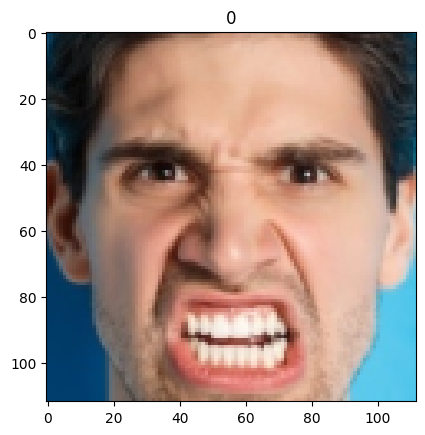

In [6]:
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.title(label)

In [7]:
class_names = train_data.classes

In [8]:
NUM_CLASSES = len(class_names)
BATCH_SIZE = 64

In [9]:
train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE
)
print(f"lengh of train dataloader: {len(train_dataloader)}")
print(f"lengh of test dataloader: {len(test_dataloader)}")

lengh of train dataloader: 23
lengh of test dataloader: 23


# Model

In [10]:
class VGGNet(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.layer = nn.Sequential(
        nn.LazyConv2d(64, (3,3), padding=1), nn.ReLU(),
        nn.MaxPool2d((2,2), (2,2)),
        nn.LazyConv2d(128, (3,3), padding=1),nn.ReLU(),
        nn.MaxPool2d((2,2), (2,2)),
        nn.LazyConv2d(256, (3,3), padding=1),nn.ReLU(),
        nn.MaxPool2d((2,2), (2,2)),
        nn.LazyConv2d(512, (3,3), padding=1),nn.ReLU(),
        nn.MaxPool2d((2,2), (2,2)),
        nn.LazyConv2d(512, (3,3), padding=1),nn.ReLU(),
        nn.MaxPool2d((2,2), (2,2)),
    )
    self.classfi = nn.Sequential(
        nn.Flatten(),
        nn.LazyLinear(4096), nn.ReLU(),
        nn.LazyLinear(1000),nn.ReLU(),
        nn.LazyLinear(num_classes)
    )
  def forward(self, x):
    x = self.layer(x)
    x = self.classfi(x)
    return x

In [11]:
model = VGGNet(NUM_CLASSES).to(device)
model

C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


VGGNet(
  (layer): Sequential(
    (0): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): LazyConv2d(0, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (9): LazyConv2d(0, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (12): LazyConv2d(0, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classfi): Seq

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

# Train fun

In [13]:
def train_epoch(model, train_dataloader, criterion, optimizer, epoch=0, log_eval=5):
  accs, losses = [], []
  start_time = time()
  for idx, (X, y) in enumerate(train_dataloader):
    X = X.to(device)
    y = y.to(device)
    model.train()
    optimizer.zero_grad()

    preds = model(X)
    loss = criterion(preds, y)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()

    total_acc = (preds.argmax(1) == y).sum().item()
    acc = total_acc / y.size(0)
    accs.append(acc)

    if idx % log_eval==0 & idx >0:
      eval_time = time()
      print("XXXXX")
      print(f"time: {eval_time - start_time} | epoch: {epoch} | step: [{idx}/{len(train_dataloader)}] \
      train acc: {sum(accs)/len(accs)} | train_loss: {sum(losses) / len(sum(losses))}\
      ")
      start_time = time()
  epoch_acc = sum(accs) / len(accs)
  epoch_loss = sum(losses) / len(losses)
  return epoch_acc, epoch_loss

# Test fun

In [14]:
def eval_epoch(model, test_dataloader, criterion):
  accs, losses = [], []
  for idx, (X, y) in enumerate(test_dataloader):
    X = X.to(device)
    y = y.to(device)

    model.eval()
    preds = model(X)
    loss = criterion(preds, y)
    losses.append(loss.item())

    total_acc = (preds.argmax(1)==y).sum().item()
    acc = total_acc / y.size(0)
    accs.append(acc)
  epoch_acc = sum(accs) / len(accs)
  epoch_loss = sum(losses) / len(losses)
  return epoch_acc, epoch_loss

# Train

In [15]:
from tqdm import tqdm
from time import time

def train(model, train_dataloader, test_dataloader, criterion, optimizer, num_epoch, device):
    model.to(device)
    train_accs, train_losses = [], []
    test_accs, test_losses = [], []
    times = []
    
    for epoch in tqdm(range(1, num_epoch+1)):
        start_time = time()
        train_acc, train_loss = train_epoch(model, train_dataloader, criterion, optimizer, epoch)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        test_acc, test_loss = eval_epoch(model, test_dataloader, criterion)
        test_accs.append(test_acc)
        test_losses.append(test_loss)

        end_epoch_time = time() - start_time
        print(f"End of epoch {epoch} | time {end_epoch_time} | train acc: {train_acc} | train_loss: {train_loss} | test acc: {test_acc} | test_loss: {test_loss}")
        times.append(end_epoch_time)
    
    metrics = {
        "train_acc": train_accs,
        "train_loss": train_losses,
        "test_acc": test_accs,
        "test_loss": test_losses,
        "times": times,
    }
    return metrics

metrics = train(model, train_dataloader, test_dataloader, criterion, optimizer, 10, device)
print(metrics)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:48<?, ?it/s]


KeyboardInterrupt: 

# Visual result

In [16]:
image, label = test_data[60]

Text(0.5, 1.0, 'Angry_human_face')

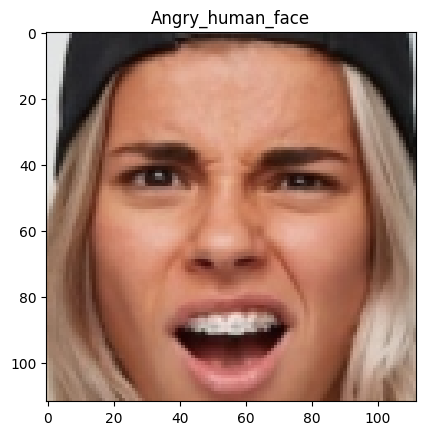

In [17]:
plt.imshow(np.transpose(image, (1, 2, 0)))
plt.title(class_names[label])

In [18]:
model.to(device)
model.eval()

# Move the image tensor to the device
image = image.to(device)

# Perform model inference on the image
with torch.no_grad():
    # Reshape the image tensor to include batch dimension if necessary
    # For example, if your model expects a batch dimension as the first dimension
    image = image.unsqueeze(0)  # Add a batch dimension

    # Make predictions
    pred = model(image)
    predicted_class = pred.argmax(1).item()

print(f"Predicted class name: {class_names[predicted_class]}")

Predicted class name: Surprised_human_face


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # Adjust the size of the linear layer input to match the output of the preceding layers
        self.fc1 = nn.Linear(128 * 56 * 56, 4096)  # Update input size
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [20]:
from torchvision import datasets, transforms


In [21]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(           # Normalize the images
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [22]:
train_dataset = datasets.ImageFolder(root=r"C:\Users\Acer\Downloads\M3\archive (6)\Dataset(Final)\train", transform=transform)
test_dataset = datasets.ImageFolder(root=r"C:\Users\Acer\Downloads\M3\archive (6)\Dataset(Final)\test", transform=transform)


In [23]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [24]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create ImageFolder instances
train_dataset = datasets.ImageFolder(root=r"C:\Users\Acer\Downloads\M3\archive (6)\Dataset(Final)\train", transform=transform)
test_dataset = datasets.ImageFolder(root=r"C:\Users\Acer\Downloads\M3\archive (6)\Dataset(Final)\test", transform=transform)

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Now you can use train_dataloader in your code
